# 0. Imports

In [29]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 1000)

from sklearn.covariance import EllipticEnvelope

import matplotlib.pyplot as plt

from scipy import stats

from dotenv import load_dotenv
load_dotenv()
import os

# 1. Coletar dados

Fizemos o scrap do site olx, setado para categoria de imoveis em recife, primeiros o extract_single_link.py para pegar os links dos sites, criamos e juntamos um json com esses links e depois fomos em cada um desses link usando scraping.py e criamos um csv com todos os dados colotados.

| Campop               | Descrição                                      |
|----------------------|--------------------------------------------------|
| find_anuncio         | o titulo do anuncio                              |
| find_condominio      | o preço do condominio                            |
| find_descri          | a descrição feita do imovel                      |
| find_endereco        | Endereço = bairro, Cidade, estado, cep           |
| find_iptu            | IPTU                                             |
| find_loc             | geralmente a rua                                 |
| find_m_quadrado      | Tamanho do imóvel em metros quadrados            |
| find_price           | Preço do imóvel                                  |
| find_vendedor        | Informações sobre o vendedor                     |
| is_academia          | Indica se há academia/centro de fitness          |
| is_apartamento       | Indica se é um apartamento                       |
| is_ar_condicionado   | Indica se tem ar condicionado                     |
| is_churrasqueira     | Indica se há churrasqueira                       |
| is_elevador          | Indica se há elevador                            |
| is_mobiliado         | Indica se o imóvel está mobiliado                |
| is_piscina           | Indica se há piscina                             |
| is_portaria          | Indica se há portaria/serviço de portaria        |
| is_profissional      | Indica se o vendedor é um profissional           |
| is_salao_festa       | Indica se há salão de festas/área de eventos     |
| is_varanda           | Indica se há varanda                             |
| n_banheiros          | Número de banheiros                              |
| n_fotos              | Número de fotos no anúncio                       |
| n_garagens           | Número de vagas/garagens                         |
| n_quartos            | Número de quartos                                |

In [222]:
path_raw = os.getenv('PATH_RAW')
df_raw = pd.read_csv(path_raw, sep=',', nrows=10000)
# df_raw = pd.read_csv(path_raw, sep=',')

In [223]:
df_raw.head(3)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,True,False,False,False,False,False,False,True,False,False,3,20,0,3
1,Apartamento para venda possui 51 metros quadra...,R$ 0 / mês,Código do anúncio: S623-1\n\nO apartamento no ...,"Boa Viagem, Recife, PE, 51021130",R$ 0,Rua Coronel Anízio Rodrigues Coelho,51m²,525000,Dream Residence Imóveis Recife,False,True,False,False,False,False,True,False,True,True,False,2,15,1,3
2,Apartamento para venda possui 124 metros quadr...,R$ 822 / mês,Código do anúncio: V2009TS-2225\n\nApartamento...,"Boa Viagem, Recife, PE, 51130000",R$ 291,Avenida Boa Viagem - de 6200/6201 ao fim,124m²,620000,Roberta Gadelha Batista,False,True,False,False,False,False,False,False,True,False,False,2,14,1,3


# 2. Realizar pré-processamento dos dados

In [224]:
df_raw.shape

(10000, 24)

In [225]:
df_0 = df_raw.copy()

Vamos tirar a descrição e anuncio, pois está fora do escopo do projeto fazer analise com esse tipo de texto

In [226]:
df_0 = df_0.drop(columns=['find_anuncio','find_descri']) 

Vamos separar o bairro e o cep

In [227]:
df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]


vamos remover as duplicadas e a coluna de endereço

In [228]:
df_0 = df_0.drop(columns=['find_endereco'])
df_0 = df_0.drop_duplicates()

In [229]:
df_0.shape

(9618, 23)

## 2.0 Tratamento de dados

### 2.0.1 Algumas classes são muito uteis como valor numerico, mas não podem ser totalmente convertidas. exemplo: o numero de quartos tem o campo '5 ou mais' vamos fazer o drop desses valores

In [230]:
df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

# df_0 = df_0[df_0['find_price'] > 10000] # vamos tirar aguns precos muito absurdos # outliers

In [231]:
df_0.shape

(8952, 23)

## 2.1 definição de tipos e criação de novas colunas derivadas

In [232]:
df_0.dtypes

find_condominio       object
find_iptu             object
find_loc              object
find_m_quadrado       object
find_price             int64
find_vendedor         object
is_academia             bool
is_apertamento          bool
is_ar_condicionado      bool
is_churrasqueira        bool
is_elevador             bool
is_mobiliado            bool
is_piscina              bool
is_portaria             bool
is_profissional         bool
is_salao_festa          bool
is_varanda              bool
n_banheiros           object
n_fotos                int64
n_garagens            object
n_quartos             object
Bairro                object
CEP                   object
dtype: object

In [233]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')


In [234]:
df_0.dtypes

find_condominio        float64
find_iptu              float64
find_loc              category
find_m_quadrado        float64
find_price             float64
find_vendedor         category
is_academia           category
is_apertamento        category
is_ar_condicionado    category
is_churrasqueira      category
is_elevador           category
is_mobiliado          category
is_piscina            category
is_portaria           category
is_profissional       category
is_salao_festa        category
is_varanda            category
n_banheiros            float64
n_fotos                float64
n_garagens             float64
n_quartos              float64
Bairro                category
CEP                   category
dtype: object

In [235]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [236]:
df_0.dtypes

find_condominio       float64
find_iptu             float64
find_loc                int16
find_m_quadrado       float64
find_price            float64
find_vendedor           int16
is_academia              int8
is_apertamento           int8
is_ar_condicionado       int8
is_churrasqueira         int8
is_elevador              int8
is_mobiliado             int8
is_piscina               int8
is_portaria              int8
is_profissional          int8
is_salao_festa           int8
is_varanda               int8
n_banheiros           float64
n_fotos               float64
n_garagens            float64
n_quartos             float64
Bairro                   int8
CEP                     int16
dtype: object

antes de tratar os dados ausentes vamos retirar anuncios que não fazem sentido 

In [237]:
df_0 = df_0[df_0['find_m_quadrado']!=0]

## 2.2 Tratamento de dados ausentes
  - vamos fazer a imputação das únicas 3 colunas que apresentam preenchimento vazio
    - find_m_quadrado
    - n_banheiros
    - n_garagens

In [238]:
df_0.isna().sum()

find_condominio         0
find_iptu               0
find_loc                0
find_m_quadrado        66
find_price              0
find_vendedor           0
is_academia             0
is_apertamento          0
is_ar_condicionado      0
is_churrasqueira        0
is_elevador             0
is_mobiliado            0
is_piscina              0
is_portaria             0
is_profissional         0
is_salao_festa          0
is_varanda              0
n_banheiros            13
n_fotos                 0
n_garagens            210
n_quartos               0
Bairro                  0
CEP                     0
dtype: int64

### 2.2.1 Removendo colunas pelo knnimputer

In [239]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

Imputing row 1/8946 with 0 missing, elapsed time: 9.824
Imputing row 101/8946 with 0 missing, elapsed time: 9.824
Imputing row 201/8946 with 0 missing, elapsed time: 9.824
Imputing row 301/8946 with 0 missing, elapsed time: 9.824
Imputing row 401/8946 with 0 missing, elapsed time: 9.824
Imputing row 501/8946 with 0 missing, elapsed time: 9.824
Imputing row 601/8946 with 0 missing, elapsed time: 9.824
Imputing row 701/8946 with 0 missing, elapsed time: 9.824
Imputing row 801/8946 with 0 missing, elapsed time: 9.824
Imputing row 901/8946 with 0 missing, elapsed time: 9.824
Imputing row 1001/8946 with 0 missing, elapsed time: 9.824
Imputing row 1101/8946 with 0 missing, elapsed time: 9.824
Imputing row 1201/8946 with 0 missing, elapsed time: 9.824
Imputing row 1301/8946 with 0 missing, elapsed time: 9.840
Imputing row 1401/8946 with 0 missing, elapsed time: 9.840
Imputing row 1501/8946 with 0 missing, elapsed time: 9.840
Imputing row 1601/8946 with 0 missing, elapsed time: 9.840
Imputing 

In [240]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)

In [241]:
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

## 2.3 Normalização e discretização dos dados

<Axes: xlabel='dist_find_m_quadrado'>

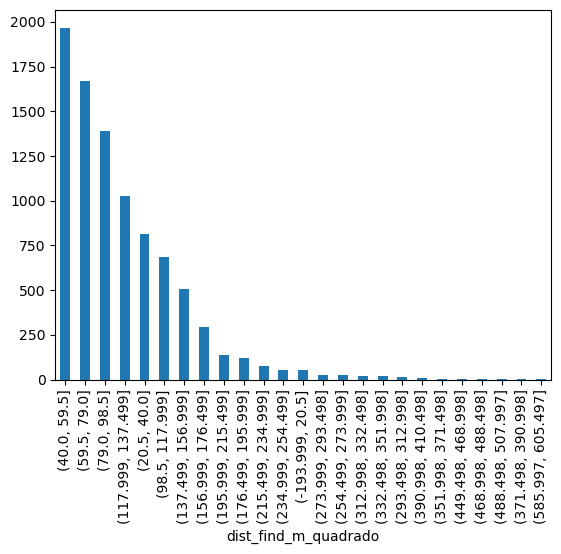

In [242]:
# fazendo a discretização do find_m_quadrado para entender melhor distribuição pelos segmentos
df_disc = df_0.copy()
df_disc['dist_find_m_quadrado'] = pd.cut(df_disc['find_m_quadrado'], bins=10000)

df_disc['dist_find_m_quadrado'].value_counts()[:25].plot(kind='bar')

C:\Users\Thamires\AppData\Local\Temp\ipykernel_16280\4106164377.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_disc['find_m_quadrado'])
C:\Users\Thamires\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Thamires\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

130.15740998087335
77.0


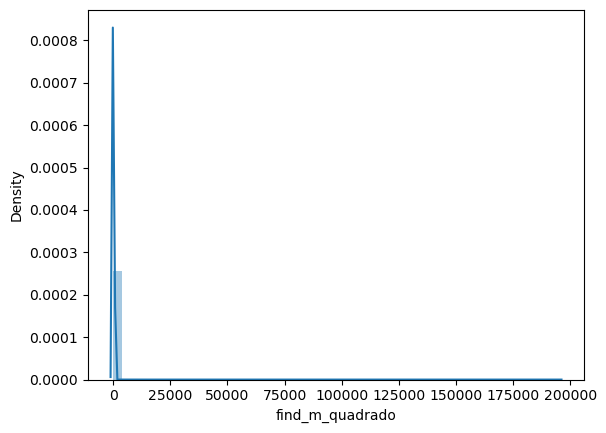

In [243]:
sns.distplot(df_disc['find_m_quadrado'])
print(df_disc['find_m_quadrado'].mean())
print(df_disc['find_m_quadrado'].median())

perceba que a intuição natural de que na a dsitribuição dos possíveis m2 na olx uma assimetria positiva se faz verdade 

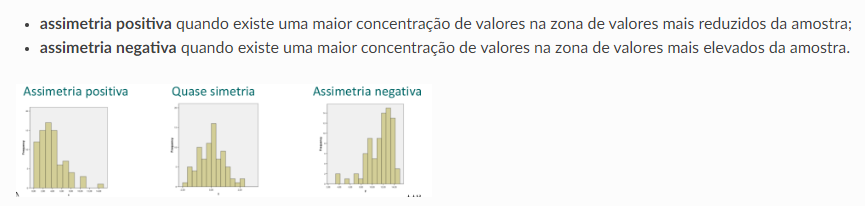

In [244]:
cat_cols = ['find_loc', 'find_vendedor', 'Bairro', 'CEP']

df_0.columns.difference(cat_cols)

Index(['find_condominio', 'find_iptu', 'find_m_quadrado', 'find_price',
       'is_academia', 'is_apertamento', 'is_ar_condicionado',
       'is_churrasqueira', 'is_elevador', 'is_mobiliado', 'is_piscina',
       'is_portaria', 'is_profissional', 'is_salao_festa', 'is_varanda',
       'n_banheiros', 'n_fotos', 'n_garagens', 'n_quartos'],
      dtype='object')

In [245]:
# minmax em todo o dataframe, exceto as colunas categóricas que não fazem sentido normalizar
cat_cols = ['find_loc', 'find_vendedor', 'Bairro', 'CEP']
numeric_cols = df_0.columns.difference(cat_cols)

df_0_norm = df_0[numeric_cols].copy()

df_0_norm[numeric_cols] = (df_0_norm[numeric_cols] - df_0_norm[numeric_cols].min()) / (df_0_norm[numeric_cols].max() - df_0_norm[numeric_cols].min()).copy()

In [246]:
df_0_norm.describe()

,find_condominio,find_iptu,find_m_quadrado,find_price,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
count,8946.000000,8.946000e+03,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000,8946.000000
mean,0.001216,7.109313e-04,0.000662,0.263016,0.467248,0.964789,0.225687,0.432484,0.682651,0.067181,0.636374,0.625419,0.978314,0.646434,0.351777,0.458967,0.780824,0.365733,0.667924
std,0.025166,1.334714e-02,0.012183,0.175653,0.498954,0.184324,0.418058,0.495448,0.465470,0.250349,0.481070,0.484042,0.145663,0.478103,0.477552,0.237146,0.252166,0.166221,0.219742
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000001,9.259251e-07,0.000272,0.143974,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.650000,0.250000,0.500000
50%,0.000122,1.851850e-06,0.000390,0.197593,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.500000,0.900000,0.250000,0.750000
75%,0.000504,2.787034e-04,0.000610,0.334677,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.950000,0.500000,0.750000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 Limpeza dos dados

In [247]:
df_1 = df_0.copy()
df_1_norm = df_0_norm.copy()

### 2.4.1 univariado

#### 2.4.1.1 find_price

<Axes: >

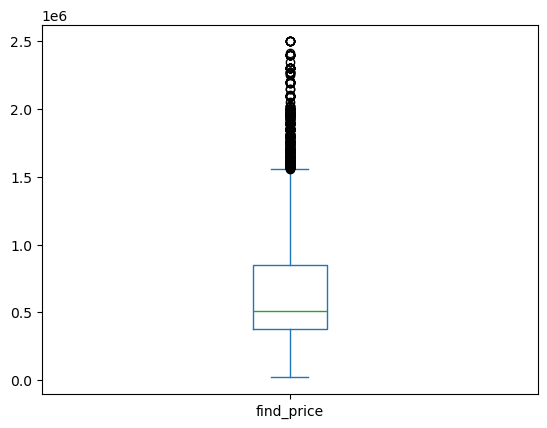

In [248]:
df_1['find_price'].plot.box()

<Axes: >

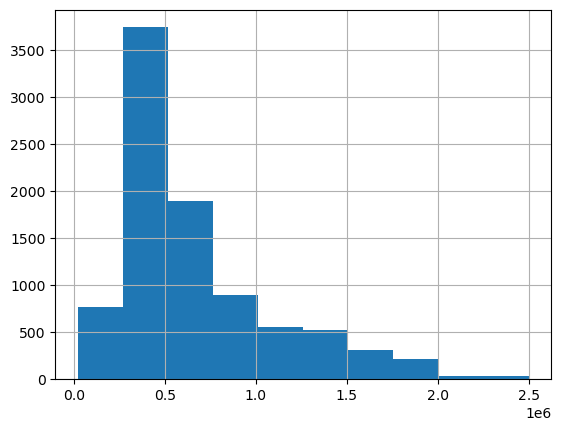

In [249]:
df_1['find_price'].hist()

In [250]:
from numpy import log10

df_1['log_find_price'] = log10(df_1['find_price'])

sem melhoras significativas no shape da distribuição, vamos usar o find_price

<Axes: >

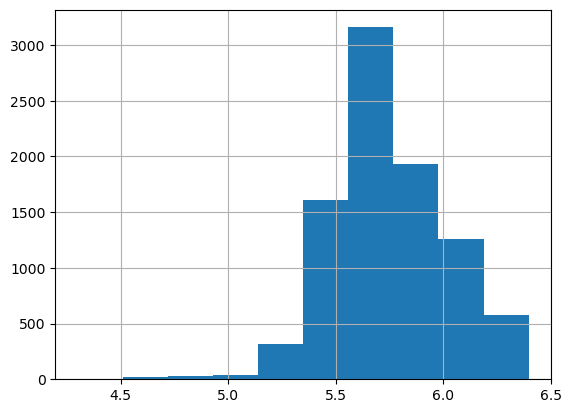

In [251]:
df_1['log_find_price'].hist()

In [252]:
q1 = df_1['find_price'].quantile(q=0.25)
q3 = df_1['find_price'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


472943.5


In [253]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['find_price'] > (q1-1.5*iqr)) & (df_1['find_price'] < (q3+1.5*iqr))]
print(len(df_1))

8946
8432


#### 2.4.1.1 find_m_quadrado

<Axes: >

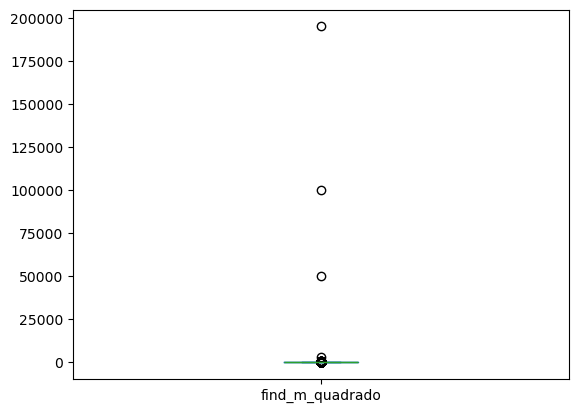

In [254]:
df_1['find_m_quadrado'].plot.box()

<Axes: >

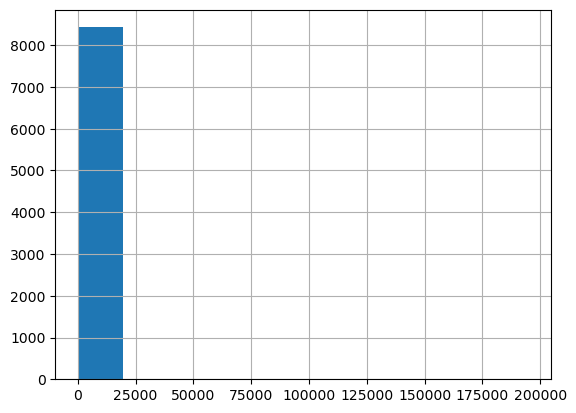

In [255]:
df_1['find_m_quadrado'].hist()

In [256]:
from numpy import log10

df_1['log_find_m_quadrado'] = log10(df_1['find_m_quadrado'])

<Axes: >

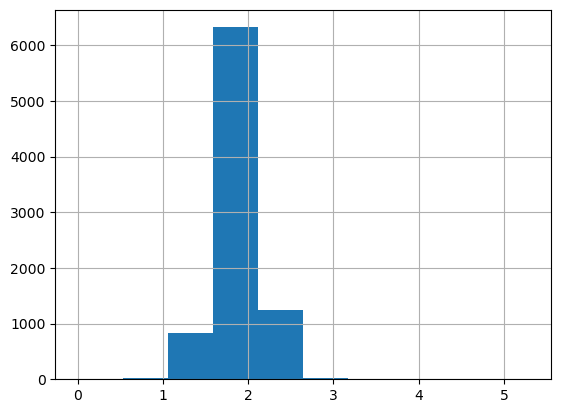

In [257]:
df_1['log_find_m_quadrado'].hist()

Já aqui vemos melhoras significativas no shape da distribuição, se aproximando bem mais de uma distribuição normal, por isso vamos utilizar a coluna log_find_m_quadrado

In [258]:
q1 = df_1['log_find_m_quadrado'].quantile(q=0.25)
q3 = df_1['log_find_m_quadrado'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


0.31742041185215064


In [259]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['log_find_m_quadrado'] > (q1-1.5*iqr)) & (df_1['log_find_m_quadrado'] < (q3+1.5*iqr))]
print(len(df_1))

8432
8360


### 2.4.2 bivariado

<Axes: xlabel='find_price', ylabel='n_banheiros'>

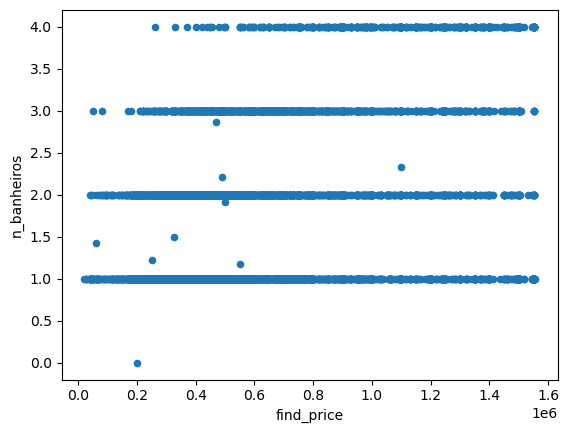

In [260]:
df_1.plot.scatter(x='find_price', y='n_banheiros')

In [261]:
df_1['price_qtdbanheiros'] = df_1['find_price'] / df_1['n_banheiros']

<Axes: >

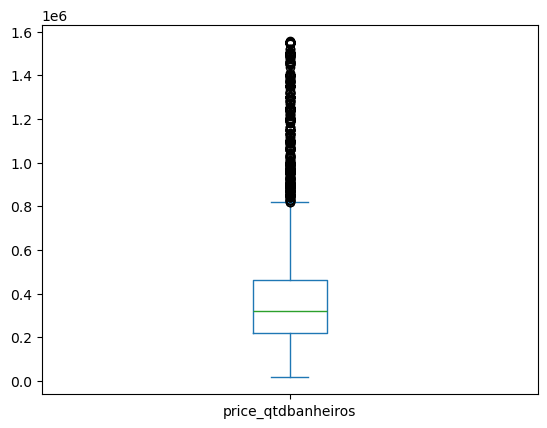

In [262]:
df_1['price_qtdbanheiros'].plot.box()

In [263]:
mad = abs(df_1['price_qtdbanheiros'] - df_1['price_qtdbanheiros'].median()).median()*(1/0.6745)

In [264]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[abs(df_1['price_qtdbanheiros']-df_1['price_qtdbanheiros'].median())/mad < 3.5]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 8360
volumetria depois: 7882


### 2.4.3 multivariado

In [265]:
detector = EllipticEnvelope(contamination=0.01)
detector.fit(df_1)

C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

EllipticEnvelope(contamination=0.01)

In [266]:
df_1['outlier'] = detector.predict(df_1)
df_1.head(3)

C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Thamires\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,log_find_m_quadrado,price_qtdbanheiros,outlier
0,1100.0,180.0,1087.0,105.0,380000.0,72.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,898.0,5.579784,2.021189,126666.666667,1
1,0.0,0.0,428.0,51.0,525000.0,184.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,15.0,1.0,3.0,10.0,493.0,5.720159,1.707570,262500.000000,1
2,822.0,291.0,34.0,124.0,620000.0,641.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,14.0,1.0,3.0,10.0,605.0,5.792392,2.093422,310000.000000,1


In [267]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[df_1['outlier'] != -1]
print(f'volumetria depois: {len(df_1)}')
df_1 = df_1.drop(columns=['outlier'])

volumetria antes: 7882
volumetria depois: 7803


# 3. Apresentar estatísticas descritivas dos dados com visualizações

In [268]:
df_2 = df_1.copy()
df_2_norm = df_1_norm.copy()

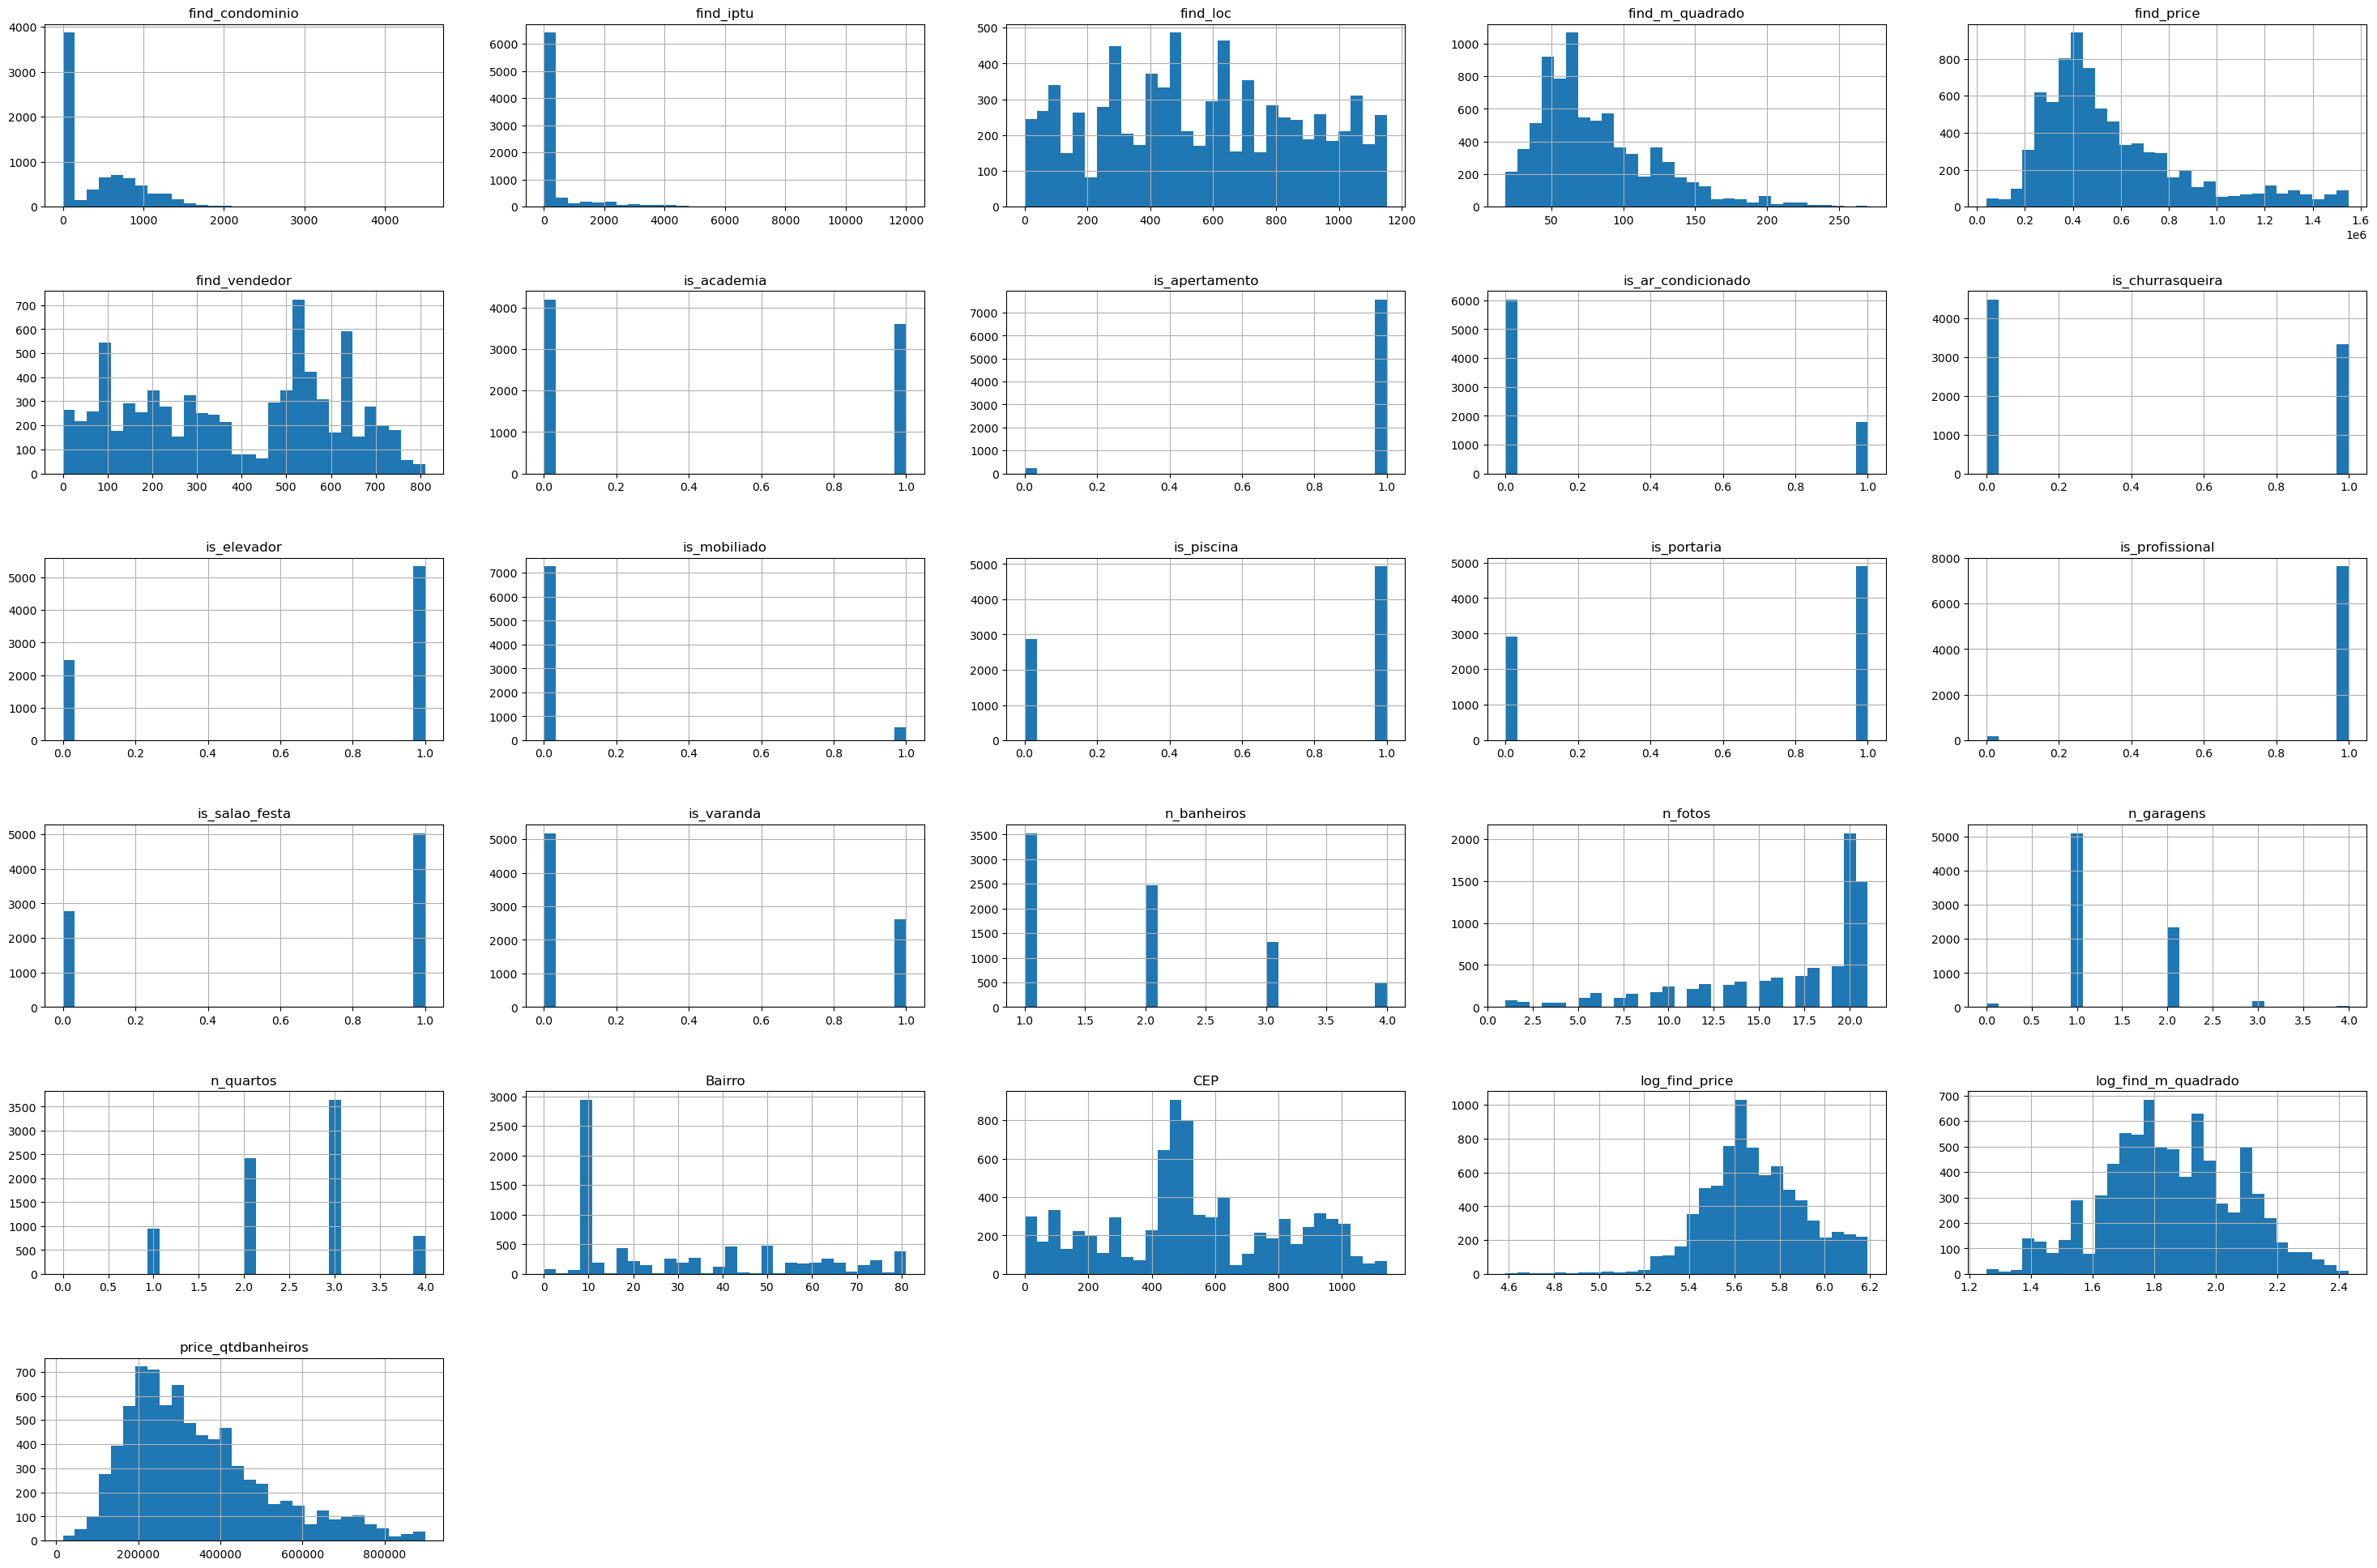

In [269]:
df_2.hist(figsize=(30, 20), bins=30)

plt.tight_layout(pad=3.0)

In [270]:
df_2.describe()

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP,log_find_price,log_find_m_quadrado,price_qtdbanheiros
count,7803.000000,7803.000000,7803.000000,7803.000000,7.803000e+03,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000,7803.000000
mean,414.552992,409.872229,562.999359,80.602462,5.627412e+05,386.395233,0.461745,0.970012,0.227605,0.426503,0.684480,0.067923,0.632449,0.627195,0.977188,0.645008,0.336281,1.839633,16.441881,1.346400,2.548379,31.362553,534.554658,5.692584,1.854034,340954.622258
std,493.736186,969.407380,319.930861,40.871615,3.027680e+05,221.772460,0.498566,0.170566,0.419313,0.494600,0.464752,0.251629,0.482169,0.483582,0.149312,0.478541,0.472467,0.917105,5.079254,0.573375,0.833981,23.819526,284.458854,0.226720,0.214309,168309.223167
min,-1.000000,-1.000000,0.000000,18.000000,3.850000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,4.585461,1.255273,16350.000000
25%,1.000000,0.000000,296.000000,51.000000,3.600000e+05,184.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,13.000000,1.000000,2.000000,10.000000,387.000000,5.556303,1.707570,215000.000000
50%,180.000000,1.000000,565.000000,69.000000,4.712160e+05,404.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,19.000000,1.000000,3.000000,20.000000,503.000000,5.673220,1.838849,300000.000000
75%,759.000000,237.000000,824.000000,100.000000,6.980000e+05,569.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,20.000000,2.000000,3.000000,49.000000,759.000000,5.843855,2.000000,429000.000000
max,4500.000000,12000.000000,1153.000000,270.000000,1.550000e+06,811.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,21.000000,4.000000,4.000000,81.000000,1142.000000,6.190332,2.431364,899001.000000


# 4. Realizar teste de hipóteses para comparação de valores de categorias e visualizar diferenças

In [271]:
df_3 = df_2.copy()
df_3_norm = df_2_norm.copy()

## 4.1 Existe diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina?
  - Mann Whitney u-test
    - Grupos não pariados
    - Teste não paramétrico
  - (H₀): Não há diferença significativa no preço médio entre imóveis com piscina e imóveis sem piscina.

In [272]:
precos_com_piscina = df_3[df_3['is_piscina'] == 1]['find_price']
precos_sem_piscina = df_3[df_3['is_piscina'] == 0]['find_price']

In [273]:
stats.shapiro(precos_com_piscina) # rejeita hip nula -> não apresenta dist normal

ShapiroResult(statistic=0.8592203855514526, pvalue=0.0)

In [274]:
stats.shapiro(precos_sem_piscina) # rejeita hip nula -> não apresenta dist normal

ShapiroResult(statistic=0.9137500524520874, pvalue=1.2629288729712816e-37)

<Axes: >

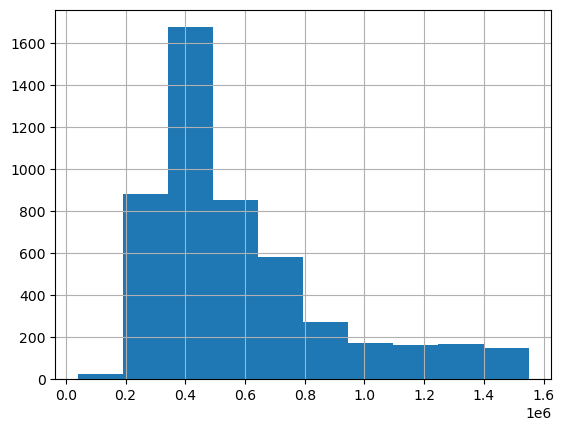

In [275]:
precos_com_piscina.hist()

<Axes: >

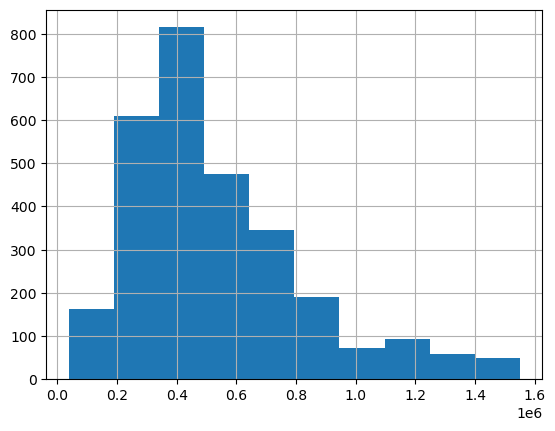

In [276]:
precos_sem_piscina.hist()

In [277]:
stat, p_value = stats.mannwhitneyu(precos_com_piscina, precos_sem_piscina, alternative='two-sided')
print(f"Statistic: {stat}, P-value: {p_value}") # rejeitamos a hipótese nula, ou seja, há uma diferença significativa no preço médio entre imóveis com e sem piscina.

Statistic: 7794307.5, P-value: 7.488369169193527e-14
